# MIR Homework 1

### 1. Basic audio signal processing

(a) Plot audio spectrogram

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import soundfile as sf


def plot_wav(filename):
    y, sr = librosa.load(filename)
    D = librosa.stft(y, win_length=2048 ,hop_length=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
    ax.set(title='Power spectrogram')
    fig.colorbar(img, ax=ax, format="%+2.f dB")

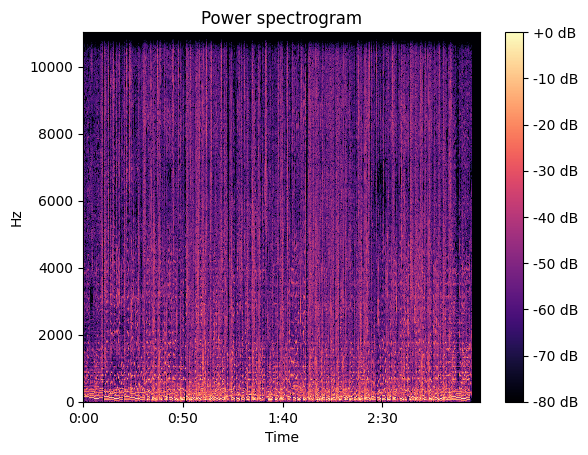

In [51]:
plot_wav("PTX_Despacito_x_Shape_Of_You.wav")

This example is a cover performed by an acappella group. All the sounds are produce by human and there are no instruments. Notice percussion sounds exists because the group has an Vocal Percussion (or Beatboxer). Because human voices unlike pianos which are Equal temperament, we can observe Harmonic series more clearly.

(b) Instantaneous frequency

$$ x_2(t) = sin(2000t + 10sin(2.5t^2)) $$
$$ f_2(t) = \frac{1}{2\pi}(\frac{d}{dt}(2000t + 10sin(2.5t^2)))$$ 
$$ = \frac{1}{2\pi}(2000 + 10cos(2.5t^2)(5t)) $$
$$ = \frac{1000}{\pi} + \frac{cos(2.5t^2)(25t)}{\pi} $$

(c) Write x1, x2 to WAV file
$$ x_1(t) = sin(2000t^2) $$
$$ x_2(t) = sin(2000t + 10sin(2.5t^2)) $$

Q. Describe what you hear in $x_1$ and $x_2$. <br>
The instantaneous frequency of $x_1$ increases between 0s and 6.28s, then begins to decrease <br>
The instantaneous frequency of $x_2$ fluctuates more as the time procgresses


In [52]:
import math

def x1(t):
    return math.sin(2000*t*t)

def x2(t):
    return math.sin(2000*t + 10*math.sin(2.5*t*t))

In [53]:
samplerate = 8000
x1_wave = [x1(t) for t in np.arange(0, 10, 1/samplerate)]
x2_wave = [x2(t) for t in np.arange(0, 10, 1/samplerate)]
sf.write('x1.wav', x1_wave, samplerate)
sf.write('x2.wav', x2_wave, samplerate)

(d) Plot spectrogram of x1, x2

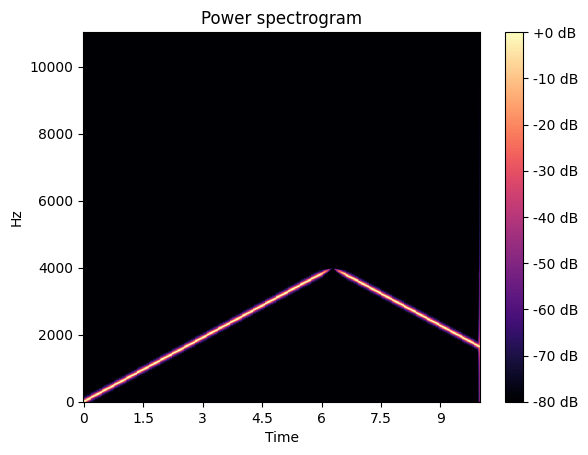

In [54]:
plot_wav('x1.wav')

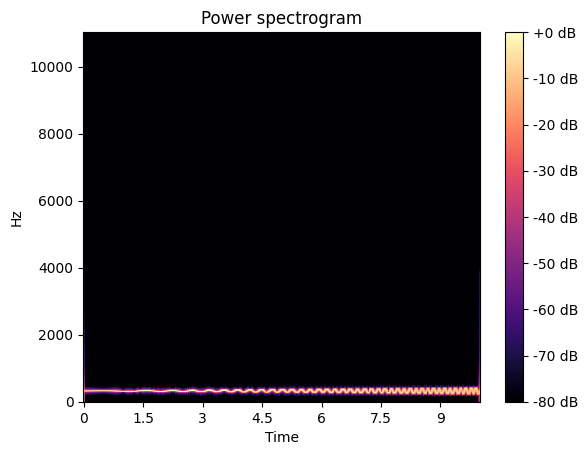

In [55]:
plot_wav('x2.wav')

### 2. Musical Key Detection

(a) Implement K-S key finding algorithm and evaluate RA and WA on SC06 audio recordings in SWD

In [56]:
from sklearn.preprocessing import normalize
import glob

filepaths = sorted(glob.glob("../SWD/01_RawData/audio_wav/*_SC06.wav"))
global_stft = []
global_cqt = []
global_cens = []

for filepath in filepaths:
    y, sr = librosa.load(filepath)

    stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=512)
    cqt = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=512)
    cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=512)

    global_stft.append(list(map(lambda l: sum(l), normalize(stft, norm='l1', axis=0))))
    global_cqt.append(list(map(lambda l: sum(l), normalize(cqt, norm='l1', axis=0))))
    global_cens.append(list(map(lambda l: sum(l), normalize(cens, norm='l1', axis=0))))

global_stft = normalize(global_stft, norm='l1', axis=1)
global_cqt = normalize(global_cqt, norm='l1', axis=1)
global_cens = normalize(global_cens, norm='l1', axis=1)

In [57]:
import scipy
import template

def get_prediction(chroma_feat):
    max_r = -1.0
    max_i = 0
    max_is_major = True
    for i, ks_major in enumerate(template.KS_major_template):
        score = scipy.stats.pearsonr(ks_major, chroma_feat)[0]
        if score > max_r:
            max_r = score
            max_i = i
    
    for i, ks_minor in enumerate(template.KS_minor_template):
        score = scipy.stats.pearsonr(ks_minor, chroma_feat)[0]
        if score > max_r:
            max_r = score
            max_i = i
            max_is_major = False

    postfix = "major" if max_is_major else "minor"
    return f'{template.tonic[max_i]} {postfix}'

def get_predictions(chroma_feat_list):
    return [get_prediction(chroma_feat) for chroma_feat in chroma_feat_list]

In [58]:
stft_predictions = get_predictions(global_stft)
cqt_predictions = get_predictions(global_cqt)
cens_predictions = get_predictions(global_cens)

In [59]:
from utils import convert

gk = pd.read_csv("../SWD/02_Annotations/ann_audio_globalkey.csv", delimiter=";")
sc06 = gk[gk.PerformanceID == "SC06"]
ground_truth = [convert(val) for val in sc06.key.values]
ground_truth

['C minor',
 'G minor',
 'D# minor',
 'A# minor',
 'D major',
 'D minor',
 'D minor',
 'F minor',
 'A minor',
 'A# minor',
 'G major',
 'A minor',
 'C# major',
 'A# minor',
 'A# minor',
 'C# major',
 'C major',
 'C minor',
 'G major',
 'F minor',
 'D# major',
 'F minor',
 'G major',
 'G minor']

In [60]:
from utils import raw_accuracy, weighted_accuracy

print(f"stft raw accuracy: {raw_accuracy(ground_truth, stft_predictions)}")
print(f"cqt raw accuracy: {raw_accuracy(ground_truth, cqt_predictions)}")
print(f"cens raw accuracy: {raw_accuracy(ground_truth, cens_predictions)}")
print(f"stft weighted accuracy: {weighted_accuracy(ground_truth, stft_predictions)}")
print(f"cqt weighted accuracy: {weighted_accuracy(ground_truth, cqt_predictions)}")
print(f"cens weighted accuracy: {weighted_accuracy(ground_truth, cens_predictions)}")

stft raw accuracy: 0.4583333333333333
cqt raw accuracy: 0.5416666666666666
cens raw accuracy: 0.5416666666666666
stft weighted accuracy: 0.5708333333333333
cqt weighted accuracy: 0.6541666666666667
cens weighted accuracy: 0.6541666666666667


# Results
|---|raw accuracy|weighted accuracy|
|---|---|---|
|stft|0.458|0.57|
|cqt|0.542|0.654|
|cens|0.542|0.654|

(b) Local key detection

In [61]:
stft_list = []
for filepath in filepaths:
    y, sr = librosa.load(filepath)
    hop_length = int(0.1 / (1/sr))
    stft = librosa.feature.chroma_stft(y=y, sr=sr, center=True, hop_length=hop_length)
    stft_list.append(stft)

In [62]:
from utils import sum_of_chroma

filepaths = sorted(glob.glob("../SWD/02_Annotations/ann_audio_localkey-ann1/*_SC06.csv"))
local_keys_list = []
for file_index, filepath in enumerate(filepaths):
    df = pd.read_csv(filepath, delimiter=';')
    local_keys = []
    for i, start, end, key in df.itertuples():
        local_keys.append((start, end, convert(key)))
    local_keys_list.append(local_keys)

In [63]:
import mir_eval

# 1 - 3250

def calculate_accuracy(frame_prediction, local_keys):
    key_index = 0
    findex = 0

    hit = 0
    weighted_hit = 0
    while key_index < len(local_keys) and findex < len(frame_prediction):
        start, end, key = local_keys[key_index]
        start *= 10
        end *= 10

        hit += (1 if frame_prediction[findex] == key else 0)
        weighted_hit += mir_eval.key.weighted_score(frame_prediction[findex], key)

        if findex > end:
            key_index += 1
        
        findex += 1
        
    return (hit, weighted_hit)

In [64]:
def sum_of_chroma(chroma_feat, start=None, end=None):
    start = 0 if (start == None or start < 0) else start
    end = chroma_feat.shape[1] if (end == None or end < 0) else end
    chroma_feat_t = np.transpose(chroma_feat)
    segment = chroma_feat_t[start:end+1]
    return sum(segment)

In [78]:
frame_predictions = []
window_size = 30
for no, stft in enumerate(stft_list):
    frames = np.transpose(stft)
    frame_preds = []
    for i in range(len(frames)):
        bins = [0] * 12
        for j in range(i-(window_size//2), i+(window_size//2)+1):
            bins += sum_of_chroma(stft, j, j+window_size)
        frame_preds.append(get_prediction(bins))
    frame_predictions.append(frame_preds)
    print(f"{i} processed")

print(len(frame_predictions))

3253 processed
956 processed
1371 processed
1598 processed
2894 processed
2404 processed
1905 processed
1140 processed
1465 processed
1809 processed


KeyboardInterrupt: 

In [ ]:
total_frames = 0
ra_local = 0
wa_local = 0
for frame_predict, local_keys in zip(frame_predictions, local_keys_list):
    total_frames += len(frame_predict)

    score_r, score_w = calculate_accuracy(frame_predict, local_keys)

    ra_local += score_r
    wa_local += score_w

ra_local /= total_frames
wa_local /= total_frames

print(f"Raw accuracy: {ra_local}")
print(f"Weighted accuracy: {wa_local}")

Raw accuracy: 0.7480024585125998
Weighted accuracy: 0.7830362630608482


(c) Apply over-segmentation under-segmentation and average-segmentation on local key detection of SWD

In [75]:
segmentations = []
for frame_predict in frame_predictions:
    seg = []
    start = 0
    end = 0
    while start < len(frame_predict) and end < len(frame_predict):
        if frame_predict[start] == frame_predict[end]:
            end += 1
        else:
            seg.append([start, end])
            start = end
            end = start
    segmentations.append(seg)

In [76]:
segmentations

[[[0, 324],
  [324, 363],
  [363, 364],
  [364, 424],
  [424, 512],
  [512, 531],
  [531, 546],
  [546, 607],
  [607, 629],
  [629, 693],
  [693, 720],
  [720, 1061],
  [1061, 1081],
  [1081, 1127],
  [1127, 1162],
  [1162, 1233],
  [1233, 1446],
  [1446, 1484],
  [1484, 1789],
  [1789, 1802],
  [1802, 1851],
  [1851, 1876],
  [1876, 1979],
  [1979, 2000],
  [2000, 2061],
  [2061, 2067],
  [2067, 2077],
  [2077, 2097],
  [2097, 2155],
  [2155, 2188],
  [2188, 2318],
  [2318, 2332],
  [2332, 2350],
  [2350, 2360],
  [2360, 2390],
  [2390, 2408],
  [2408, 2409],
  [2409, 2436],
  [2436, 2474],
  [2474, 2514],
  [2514, 2550],
  [2550, 2575],
  [2575, 2596],
  [2596, 2644],
  [2644, 2672],
  [2672, 2696],
  [2696, 2718],
  [2718, 2848],
  [2848, 2867],
  [2867, 2876],
  [2876, 2951],
  [2951, 2978],
  [2978, 3008],
  [3008, 3009],
  [3009, 3011],
  [3011, 3029],
  [3029, 3035],
  [3035, 3056],
  [3056, 3077],
  [3077, 3088],
  [3088, 3105],
  [3105, 3132],
  [3132, 3147]]]

In [77]:
i = 1
for seg, local_keys in zip(segmentations, local_keys_list):
    ans_interval = [[start, end] for start,end,key in local_keys]

    score_u = mir_eval.chord.underseg(np.array(seg), np.array(ans_interval))
    score_o = mir_eval.chord.overseg(np.array(seg), np.array(ans_interval))
    score_a = mir_eval.chord.seg(np.array(seg), np.array(ans_interval))

    print(f"-----SC06 {i}-----")
    print(f"underseg: {score_u}")
    print(f"overseg {score_o}")
    print(f"avgseg {score_a}")

    i+=1

-----SC06 1-----
underseg: 0.9972278691554242
overseg 0.9141468064823641
avgseg 0.9141468064823641


(d) Propose any better global and local key detection algorithm (Bonus)